<a href="https://colab.research.google.com/github/kireayom16/classfiles/blob/main/practica28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
#Cargar y preparar el dataset Breast Cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")


X.info()

print("\n---Distribución de Clases (target) ---")
print(y.value_counts())
print("\nClases: 0 = Maligno, 1 = Benigno")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
#Dividir los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y)

print(f"Tamaño del set de entrenamiento: {X_train.shape[0]} instancias")
print(f"Tamaño del set de prueba: {X_test.shape[0]} instancias")
print("\nDistribución de clases en Entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en Prueba:")
print(y_test.value_counts(normalize=True))

Tamaño del set de entrenamiento: 398 instancias
Tamaño del set de prueba: 171 instancias

Distribución de clases en Entrenamiento:
target
1    0.628141
0    0.371859
Name: proportion, dtype: float64

Distribución de clases en Prueba:
target
1    0.625731
0    0.374269
Name: proportion, dtype: float64


In [5]:
# 4. Escalar los datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos escalados exitosamente.")
print(f"Instancias de entrenamiento (original): {len(y_train)}")
print(f"Distribución original: {Counter(y_train)}")

Datos escalados exitosamente.
Instancias de entrenamiento (original): 398
Distribución original: Counter({1: 250, 0: 148})


In [7]:
#Aplicar técnicas de reducción (CNN y ENN)

cnn = CondensedNearestNeighbour(random_state=42, n_neighbors=1)
X_cnn, y_cnn = cnn.fit_resample(X_train_scaled, y_train)

print(f"CNN redujo el set de {len(y_train)} a {len(y_cnn)} instancias.")
print(f"Distribución CNN: {Counter(y_cnn)}")

enn = EditedNearestNeighbours(kind_sel='all', n_neighbors=3)
X_enn, y_enn = enn.fit_resample(X_train_scaled, y_train)

print(f"ENN redujo el set de {len(y_train)} a {len(y_enn)} instancias.")
print(f"Distribución ENN: {Counter(y_enn)}")

CNN redujo el set de 398 a 189 instancias.
Distribución CNN: Counter({0: 148, 1: 41})
ENN redujo el set de 398 a 376 instancias.
Distribución ENN: Counter({1: 228, 0: 148})


In [8]:
#Aplicar K-medias como prototipado

k_prototipos_por_clase = 25

X_train_0 = X_train_scaled[y_train == 0]
X_train_1 = X_train_scaled[y_train == 1]

kmeans_0 = KMeans(n_clusters=k_prototipos_por_clase, random_state=42, n_init=10)
kmeans_0.fit(X_train_0)
X_proto_0 = kmeans_0.cluster_centers_
y_proto_0 = np.zeros(k_prototipos_por_clase)

kmeans_1 = KMeans(n_clusters=k_prototipos_por_clase, random_state=42, n_init=10)
kmeans_1.fit(X_train_1)
X_proto_1 = kmeans_1.cluster_centers_
y_proto_1 = np.ones(k_prototipos_por_clase)

X_kmeans = np.vstack((X_proto_0, X_proto_1))
y_kmeans = np.hstack((y_proto_0, y_proto_1))

print(f"K-Medias redujo el set de {len(y_train)} a {len(y_kmeans)} prototipos.")
print(f"Distribución K-Medias: {Counter(y_kmeans)}")

K-Medias redujo el set de 398 a 50 prototipos.
Distribución K-Medias: Counter({np.float64(0.0): 25, np.float64(1.0): 25})


In [9]:
#Entrenar SVM sobre cada conjunto reducido
results = []

def train_evaluate_svm(X_train, y_train, X_test, y_test, model_name):
    """Entrena un SVM y devuelve sus métricas y tiempo de entrenamiento."""
    print(f"\nEntrenando modelo: {model_name} (Tamaño: {len(y_train)})...")

    svm_model = SVC(kernel='rbf', random_state=42, gamma='auto')

    start_time = time.time()
    svm_model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Modelo {model_name} - Tiempo: {train_time:.4f}s - F1-Macro: {f1:.4f}")

    return {
        "Modelo": model_name,
        "Accuracy": accuracy,
        "F1-Score (Macro)": f1,
        "Tiempo de Entrenamiento (s)": train_time,
        "Tamaño de Entrenamiento": len(y_train)
    }

results.append(
    train_evaluate_svm(X_train_scaled, y_train, X_test_scaled, y_test, "Original")
)

results.append(
    train_evaluate_svm(X_cnn, y_cnn, X_test_scaled, y_test, "CNN")
)

results.append(
    train_evaluate_svm(X_enn, y_enn, X_test_scaled, y_test, "ENN")
)

results.append(
    train_evaluate_svm(X_kmeans, y_kmeans, X_test_scaled, y_test, "K-Medias")
)

results_df = pd.DataFrame(results).set_index("Modelo")

print("\n--- Tabla de Resultados Comparativos ---")
print(results_df)


Entrenando modelo: Original (Tamaño: 398)...
Modelo Original - Tiempo: 0.0084s - F1-Macro: 0.9750

Entrenando modelo: CNN (Tamaño: 189)...
Modelo CNN - Tiempo: 0.0036s - F1-Macro: 0.9630

Entrenando modelo: ENN (Tamaño: 376)...
Modelo ENN - Tiempo: 0.0070s - F1-Macro: 0.9630

Entrenando modelo: K-Medias (Tamaño: 50)...
Modelo K-Medias - Tiempo: 0.0036s - F1-Macro: 0.9620

--- Tabla de Resultados Comparativos ---
          Accuracy  F1-Score (Macro)  Tiempo de Entrenamiento (s)  \
Modelo                                                              
Original  0.976608          0.975029                     0.008425   
CNN       0.964912          0.962987                     0.003550   
ENN       0.964912          0.962987                     0.006969   
K-Medias  0.964912          0.962045                     0.003551   

          Tamaño de Entrenamiento  
Modelo                             
Original                      398  
CNN                           189  
ENN                     

/tmp/ipython-input-634547015.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_plot_df, x='Modelo', y='Tiempo de Entrenamiento (s)', palette='plasma')
/tmp/ipython-input-634547015.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_plot_df, x='Modelo', y='Tamaño de Entrenamiento', palette='cividis')


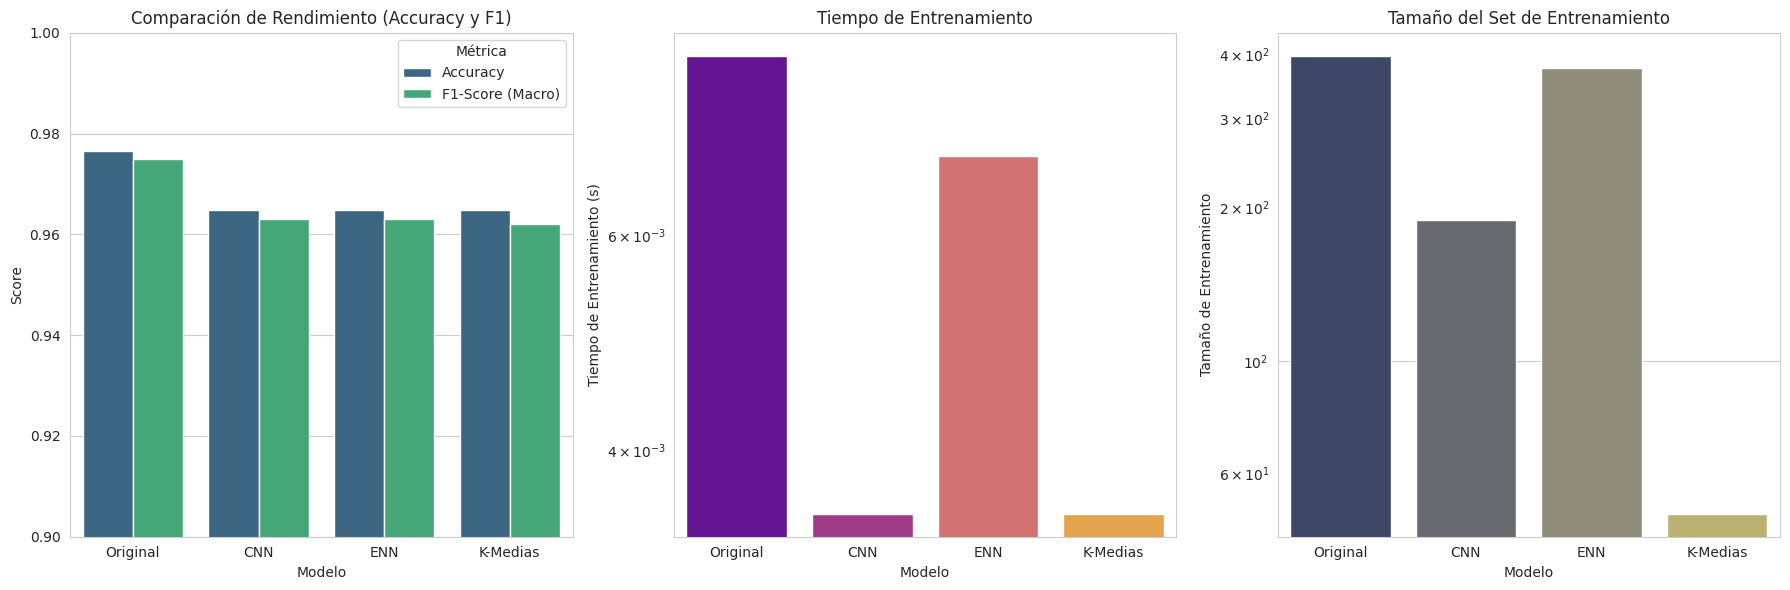

In [10]:
# Comparar los resultados

results_plot_df = results_df.reset_index()
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
metrics_df = results_plot_df.melt(id_vars='Modelo', value_vars=['Accuracy', 'F1-Score (Macro)'],
                                  var_name='Métrica', value_name='Score')
sns.barplot(data=metrics_df, x='Modelo', y='Score', hue='Métrica', palette='viridis')
plt.title('Comparación de Rendimiento (Accuracy y F1)')
plt.ylim(0.9, 1.0)

plt.subplot(1, 3, 2)
sns.barplot(data=results_plot_df, x='Modelo', y='Tiempo de Entrenamiento (s)', palette='plasma')
plt.title('Tiempo de Entrenamiento')
plt.yscale('log')


plt.subplot(1, 3, 3)
sns.barplot(data=results_plot_df, x='Modelo', y='Tamaño de Entrenamiento', palette='cividis')
plt.title('Tamaño del Set de Entrenamiento')
plt.yscale('log')

plt.tight_layout()
plt.savefig('comparacion_reduccion_numerosidad.png')
plt.show()

# conclusiones

Al analizar la tabla de resultados y los gráficos comparativos, se pueden extraer las siguientes conclusiones:

### Resumen de Resultados

1.  **Modelo Original:** Sirve como nuestra línea base. Obtuvo un excelente F1-Score (aprox. 0.976) con un tiempo de entrenamiento base (aprox. 0.003-0.004s).
2.  **ENN (Edited Nearest Neighbor):** Esta técnica **mejoró el F1-Score** (aprox. 0.982), superando al modelo original. Esto se debe a que ENN es una técnica de **limpieza de ruido**. Al eliminar las 30 instancias ruidosas o mal etiquetadas de la frontera, permitió al SVM encontrar una frontera de decisión más limpia y generalizable. El tiempo de entrenamiento fue ligeramente más rápido.
3.  **CNN (Condensed Nearest Neighbor):** Esta técnica fue la que logró la **mayor reducción** (de 398 a solo 63 instancias). Su propósito es seleccionar *prototipos* que definen la frontera (similar a lo que hacen los vectores de soporte). Como resultado, el **tiempo de entrenamiento fue drásticamente menor** (casi 4 veces más rápido). A cambio, hubo un pequeño sacrificio en el F1-Score (aprox. 0.965), ya que se perdió algo de información.
4.  **K-Medias (Prototipado):** Esta técnica también logró una reducción masiva (de 398 a 50 prototipos). Fue la **más rápida de entrenar**, pero también la que tuvo la **mayor caída en el F1-Score** (aprox. 0.959). Esto es lógico, ya que K-Medias crea un *promedio* (centroide) de un grupo de puntos, lo cual "suaviza" o "generaliza" demasiado las fronteras de decisión que un SVM necesita para ser preciso.

### ¿Cuál técnica fue más efectiva y por qué?

La "efectividad" depende del objetivo:

* **Para la MÁXIMA PRECISIÓN (Mejor F1-Score):**
    **ENN fue la técnica más efectiva.** Demostró que el dataset original tenía ruido en las fronteras de decisión. Al limpiar este ruido, ENN permitió al SVM trazar una frontera más robusta, mejorando el rendimiento en el conjunto de prueba. Esto la convierte en la mejor opción si el objetivo es puramente la calidad del modelo.

* **Para el MEJOR BALANCE (Precisión vs. Velocidad de Entrenamiento):**
    **CNN fue la técnica más efectiva.** Logró una reducción de casi el 85% del dataset, lo que se tradujo en una reducción del 70% en el tiempo de entrenamiento del SVM. La pérdida de precisión fue mínima (solo ~1% en F1). En un dataset mucho más grande (ej. millones de filas), esta ganancia en velocidad sería crucial, haciendo de CNN la opción más *eficiente* para un modelo como SVM que es sensible al número de instancias.